# SIR Model with DeepXDE

By Allan P. Engsig-Karup (apek@dtu.dk)
March 8, 2021

In this notebook, we generate data using a SIR model and learn (discover) the truth parameters from the data series using PINNs.

 $\frac{dS}{dt}=-\beta IS $

 $\frac{dI}{dt}=bIS-kI$

Based on the above equations and $R=1-S-I$ we get the ODE for $R$.


$\frac{dR}{dt}=-\frac{dS}{dt}-\frac{dI}{dt}=kI$

We learn this model using synthetic data obtained from a numerical simulation through an ODE solver.

Install packages (run only once in the runtime)

In [15]:
!pip install deepxde

Imports and functions

In [16]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re

import matplotlib.pyplot as plt
import numpy as np
import requests

import deepxde as dde
from deepxde.backend import torch

import numpy as np
from scipy.integrate import odeint

# SIR model parameters
tfinal = 200   # compute ground truth
t0predict = 75 # timie limit for traininig data, extrapolate from this time
b=0.5 
k=1/3

# parameters to be identified
C1 = torch.tensor(1.0, requires_grad=True)
C2 = torch.tensor(1.0, requires_grad=True)

C1true = b
C2true = k

# SIR model definition
def SIR(z, t):
    return [
      -b*z[0]*z[1]  ,
       b*z[0]*z[1] - k*z[1] ,
       k*z[1] 
    ]

# Generate true solution
dt = .25 # time step
t_true = np.arange(0, tfinal, dt)
x0_train = [9.99999833e-01, 1.66666667e-07, 0.00000000e+00] # Initial condition
x_true = odeint(SIR, x0_train, t_true)

# Generate measurement data
dt = .1 # time step 
t_test = np.arange(dt/2.0, tfinal, dt) # to be used for prediction
x_true = odeint(SIR, x0_train, t_test) 
t_test = t_test.reshape(len(t_test),-1)
t_train = np.arange(0, t0predict, dt)
x_train = odeint(SIR, x0_train, t_train)
t_train = t_train.reshape((len(t_train),1)) # reshape array to fit with DeepXDE

Define data and BCs

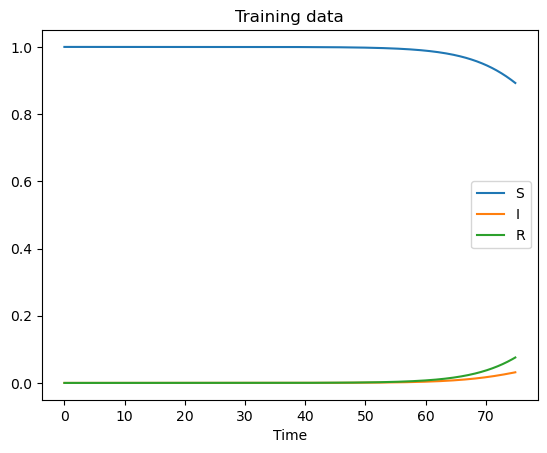

In [17]:
def boundary(_, on_initial):
    return on_initial

# SIR model definition
def SIR_system(t,z):
    z0, z1, z2 = z[:,0:1], z[:,1:2], z[:,2:]
    dz0_t = dde.grad.jacobian(z, t, i=0)
    dz1_t = dde.grad.jacobian(z, t, i=1)
    dz2_t = dde.grad.jacobian(z, t, i=2)
    return [
      dz0_t - ( -C1*z0*z1 )  ,
      dz1_t - ( C1*z0*z1 - C2*z1 ),
      dz2_t - ( C2*z1 )
    ]

# define time domain
geom = dde.geometry.TimeDomain(0, tfinal)

# Initial conditions
ic1 = dde.IC(geom, lambda X: x0_train[0], boundary, component=0) # S
ic2 = dde.IC(geom, lambda X: x0_train[1], boundary, component=1) # I
ic3 = dde.IC(geom, lambda X: x0_train[2], boundary, component=2) # R

# Get the training data (synthetic data, but could be any data)
observe_t = t_train
observe_z = x_train
#observe_t, ob_y = gen_traindata()
observe_z0 = dde.PointSetBC(observe_t, observe_z[:, 0:1], component=0)
observe_z1 = dde.PointSetBC(observe_t, observe_z[:, 1:2], component=1)
observe_z2 = dde.PointSetBC(observe_t, observe_z[:, 2:], component=2)

# define data object
data = dde.data.PDE(
    geom,
    SIR_system,
    [ic1, ic2, ic3, observe_z0, observe_z1, observe_z2],
    num_domain=800,
    num_boundary=2,
    anchors=t_test
)

plt.plot(observe_t, observe_z)
plt.xlabel('Time')
plt.legend(['S','I','R'])
plt.title('Training data')
plt.show()

Train network

In [18]:
# define FNN architecture and compile
net = dde.maps.FNN([1] + [20] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

# callbacks for storing results, and outputting the values of C1, C2 subject to parameter estimation (model calibration)
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue(
    [C1,C2], 
    period=1,
    filename=fnamevar
)

losshistory, train_state = model.train(epochs=70000, callbacks=[variable])

Compiling model...
'compile' took 0.001187 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.42e-01, 8.97e-01, 3.24e-01, 1.00e+00, 2.78e-14, 0.00e+00, 2.28e+00, 3.31e-01, 1.50e-01]    [1.42e-01, 8.97e-01, 3.24e-01, 1.00e+00, 2.78e-14, 0.00e+00, 2.28e+00, 3.31e-01, 1.50e-01]    []  
1000      [2.56e-05, 9.01e-07, 7.37e-06, 6.72e-09, 4.81e-09, 8.21e-10, 2.47e-04, 4.13e-05, 9.91e-05]    [2.56e-05, 9.01e-07, 7.37e-06, 6.72e-09, 4.81e-09, 8.21e-10, 2.47e-04, 4.13e-05, 9.91e-05]    []  
2000      [1.72e-05, 7.52e-07, 2.66e-06, 2.18e-09, 9.48e-09, 3.38e-11, 1.62e-04, 3.81e-05, 6.84e-05]    [1.72e-05, 7.52e-07, 2.66e-06, 2.18e-09, 9.48e-09, 3.38e-11, 1.62e-04, 3.81e-05, 6.84e-05]    []  
3000      [1.15e-05, 4.52e-07, 3.04e-06, 1.90e-09, 6.37e-09, 1.99e-11, 1.20e-04, 3.48e-05, 5.63e-05]    [1.15e-05, 4

39000     [1.76e-06, 2.18e-06, 4.15e-06, 1.20e-08, 1.56e-09, 1.47e-09, 4.95e-06, 1.45e-05, 2.22e-06]    [1.76e-06, 2.18e-06, 4.15e-06, 1.20e-08, 1.56e-09, 1.47e-09, 4.95e-06, 1.45e-05, 2.22e-06]    []  
40000     [1.53e-06, 2.27e-06, 4.06e-06, 1.26e-07, 3.77e-09, 2.22e-08, 5.05e-06, 1.40e-05, 1.94e-06]    [1.53e-06, 2.27e-06, 4.06e-06, 1.26e-07, 3.77e-09, 2.22e-08, 5.05e-06, 1.40e-05, 1.94e-06]    []  
41000     [1.49e-06, 2.12e-06, 3.93e-06, 3.15e-09, 2.30e-10, 2.11e-08, 3.66e-06, 1.34e-05, 1.93e-06]    [1.49e-06, 2.12e-06, 3.93e-06, 3.15e-09, 2.30e-10, 2.11e-08, 3.66e-06, 1.34e-05, 1.93e-06]    []  
42000     [1.36e-06, 1.76e-06, 3.15e-06, 1.11e-09, 2.88e-09, 1.84e-09, 3.15e-06, 1.45e-05, 1.29e-06]    [1.36e-06, 1.76e-06, 3.15e-06, 1.11e-09, 2.88e-09, 1.84e-09, 3.15e-06, 1.45e-05, 1.29e-06]    []  
43000     [1.31e-06, 2.18e-06, 3.66e-06, 6.97e-08, 1.39e-08, 4.45e-08, 2.81e-06, 1.22e-05, 1.50e-06]    [1.31e-06, 2.18e-06, 3.66e-06, 6.97e-08, 1.39e-08, 4.45e-08, 2.81e-06, 1.22e-05, 1.5

Plot identified parameters

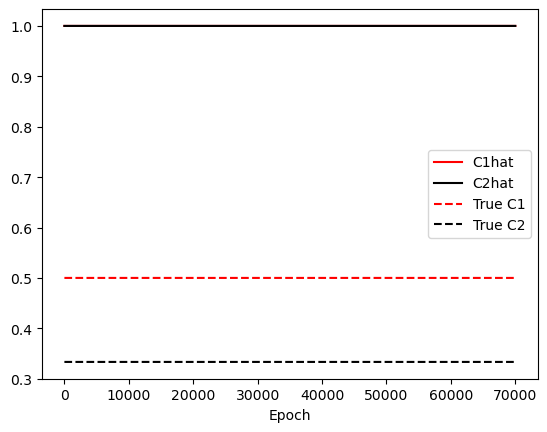

In [21]:
# reopen saved data using callbacks in fnamevar 
lines = open(fnamevar, "r").readlines()

# read output data in fnamevar (this line is a long story...)
Chat = np.array([np.fromstring(min(re.findall(re.escape('[')+"(.*?)"+re.escape(']'),line), key=len), sep=',') for line in lines])

l,c = Chat.shape

plt.plot(range(l),Chat[:,0],'r-')
plt.plot(range(l),Chat[:,1],'k-')
plt.plot(range(l),np.ones(Chat[:,0].shape)*C1true,'r--')
plt.plot(range(l),np.ones(Chat[:,1].shape)*C2true,'k--')
plt.legend(['C1hat','C2hat','True C1','True C2'],loc = "right")
plt.xlabel('Epoch')
plt.show()

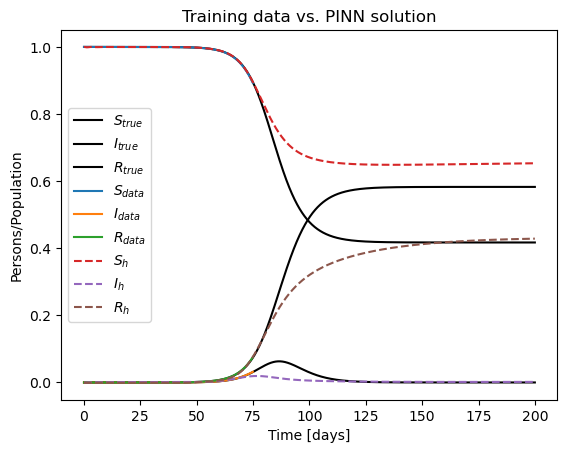

In [23]:
yhat = model.predict(t_test)

plt.plot(t_test,x_true,'k',observe_t, observe_z,'-',t_test, yhat,'--')
plt.ylabel('Persons/Population')
plt.xlabel('Time [days]')
plt.legend(['$S_{true}$','$I_{true}$','$R_{true}$','$S_{data}$','$I_{data}$','$R_{data}$','$S_h$','$I_h$','$R_h$'])
plt.title('Training data vs. PINN solution')
plt.show()